In [18]:
# Initialize Otter
import otter
grader = otter.Notebook("lab6.ipynb")

---

<h1><center>SDSE Lab 6 <br><br> Ensemble methods and hyperparameter tuning </center></h1>

---




In this lab exercise we will apply several classification models to a problem in astrophysics. The problem is described [here](https://satyam5120.medium.com/predicting-a-pulsar-star-using-different-machine-learning-algorithms-d22ee8fc71b4) and [here](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). It consists in labeling objects in space as pulsars or not pulsars, based on the properties of an integrated profile of observations and the DM-SNR curve. What these are exactly is not important to the data scientist. The given dataset has 8 feature columns:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Our procedure will follow these steps:
1. Load the data
2. Remove incomplete samples
3. Visual inspection of histograms, box plots, and correlation matrix
4. Extracting the test dataset
5. Hyperparameter tuning of of logistic regression with grid search
6. Support vector machine
7. Random forest
8. AdaBoost
9. Gradient Boosted Trees
10. Final model selection

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lab6_utils as lab6
import os
rng_seed = 2434

# 1. Load the data

+ Load the data file `pulsar_data_train.csv` into a Pandas dataframe using [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
+ Save the column headers corresponding to feature names to the variable `feature_names` ([Hint](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html))

In [87]:
os.chdir('/Users/dagu/Documents/UCB_US/Courses/292B_Data_Analysis/Labs/My_labs/LabRatzTeam/Lab6')
df = pd.read_csv('pulsar_data.csv')
#print(df)
feature_names = df.columns[:8]
print(feature_names)
D = len(feature_names)
print(D)

        Mean of the integrated profile  \
0                           121.156250   
1                            76.968750   
2                           130.585938   
3                           156.398438   
4                            84.804688   
...                                ...   
12523                       124.312500   
12524                       115.617188   
12525                       116.031250   
12526                       135.664062   
12527                       120.726562   

        Standard deviation of the integrated profile  \
0                                          48.372971   
1                                          36.175557   
2                                          53.229534   
3                                          48.865942   
4                                          36.117659   
...                                              ...   
12523                                      53.179053   
12524                                      46.7

In [30]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Remove incomplete samples
The image below is a visualization of [`df.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html). Notice that 3 of the features have a significant number of missing (null) values.

<AxesSubplot:>

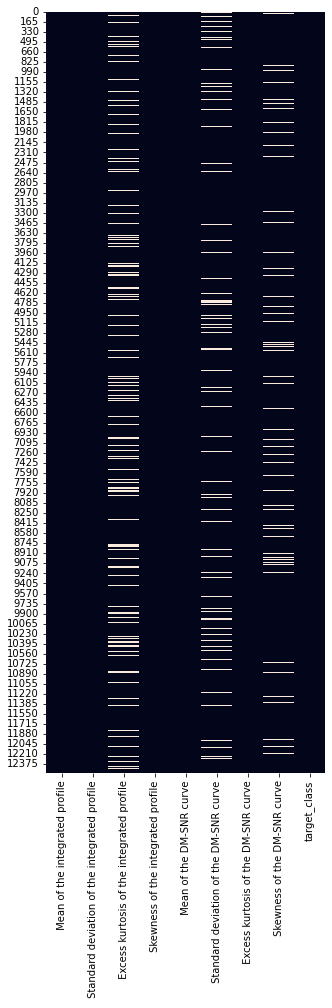

In [31]:
plt.figure(figsize=(5,14))
sns.heatmap(df.isnull(),  cbar=False)

### 2.1 Count null values

Find the number of null values for each feature column of `df` (excluding `target_class`). Store the null counts in the provided dictionary.

In [64]:
null_counts = dict().fromkeys(feature_names)
df_null = df.isnull()
for feat in feature_names:
    print(feat)
    cpt = 0
    for k in range(len(df_null[feat])):
        if df_null[feat][k]:
            cpt+=1
    null_counts[feat] = cpt
print(null_counts)

 Mean of the integrated profile
 Standard deviation of the integrated profile
 Excess kurtosis of the integrated profile
 Skewness of the integrated profile
 Mean of the DM-SNR curve
 Standard deviation of the DM-SNR curve
 Excess kurtosis of the DM-SNR curve
 Skewness of the DM-SNR curve
{' Mean of the integrated profile': 0, ' Standard deviation of the integrated profile': 0, ' Excess kurtosis of the integrated profile': 1735, ' Skewness of the integrated profile': 0, ' Mean of the DM-SNR curve': 0, ' Standard deviation of the DM-SNR curve': 1178, ' Excess kurtosis of the DM-SNR curve': 0, ' Skewness of the DM-SNR curve': 625}


In [65]:
grader.check("q2p1")

q2p1 results: All test cases passed!

### 2.2 Remove rows with null values

Remove all rows from the data frame that contain null values ([Hint](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html))

In [103]:
df = df.dropna(axis='index')

In [104]:
grader.check("q2p2")

q2p2 results: All test cases passed!

# 3. Class imbalance

Find the number of data points in each of the two classes. Save the number of class 0 data and class 1 data to `N0` and `N1` respectively.

In [120]:
# N0 = 0, N1 = 0
# for classe in df['target_class']:
#     if classe == 0:
#         N0 += 1
#     else:
#         N1 += 1
N0 = np.sum([1 for classe in df['target_class'] if classe == 0])
N1 = np.sum([1 for classe in df['target_class'] if classe == 1])

print(N0)
print(N1)

8423
850


In [121]:
grader.check("q3")

q3 results: All test cases passed!

# Plotting p(X)

Here are two visualizations of the marginal distribution of each of the inputs. The one on the left is a histogram, created with seaborn's `histplot`. The one on the right is a box or whisker plot, created with seaborn's `boxplot`. See [here](https://en.wikipedia.org/wiki/Box_plot) for more information about this type of visualization.

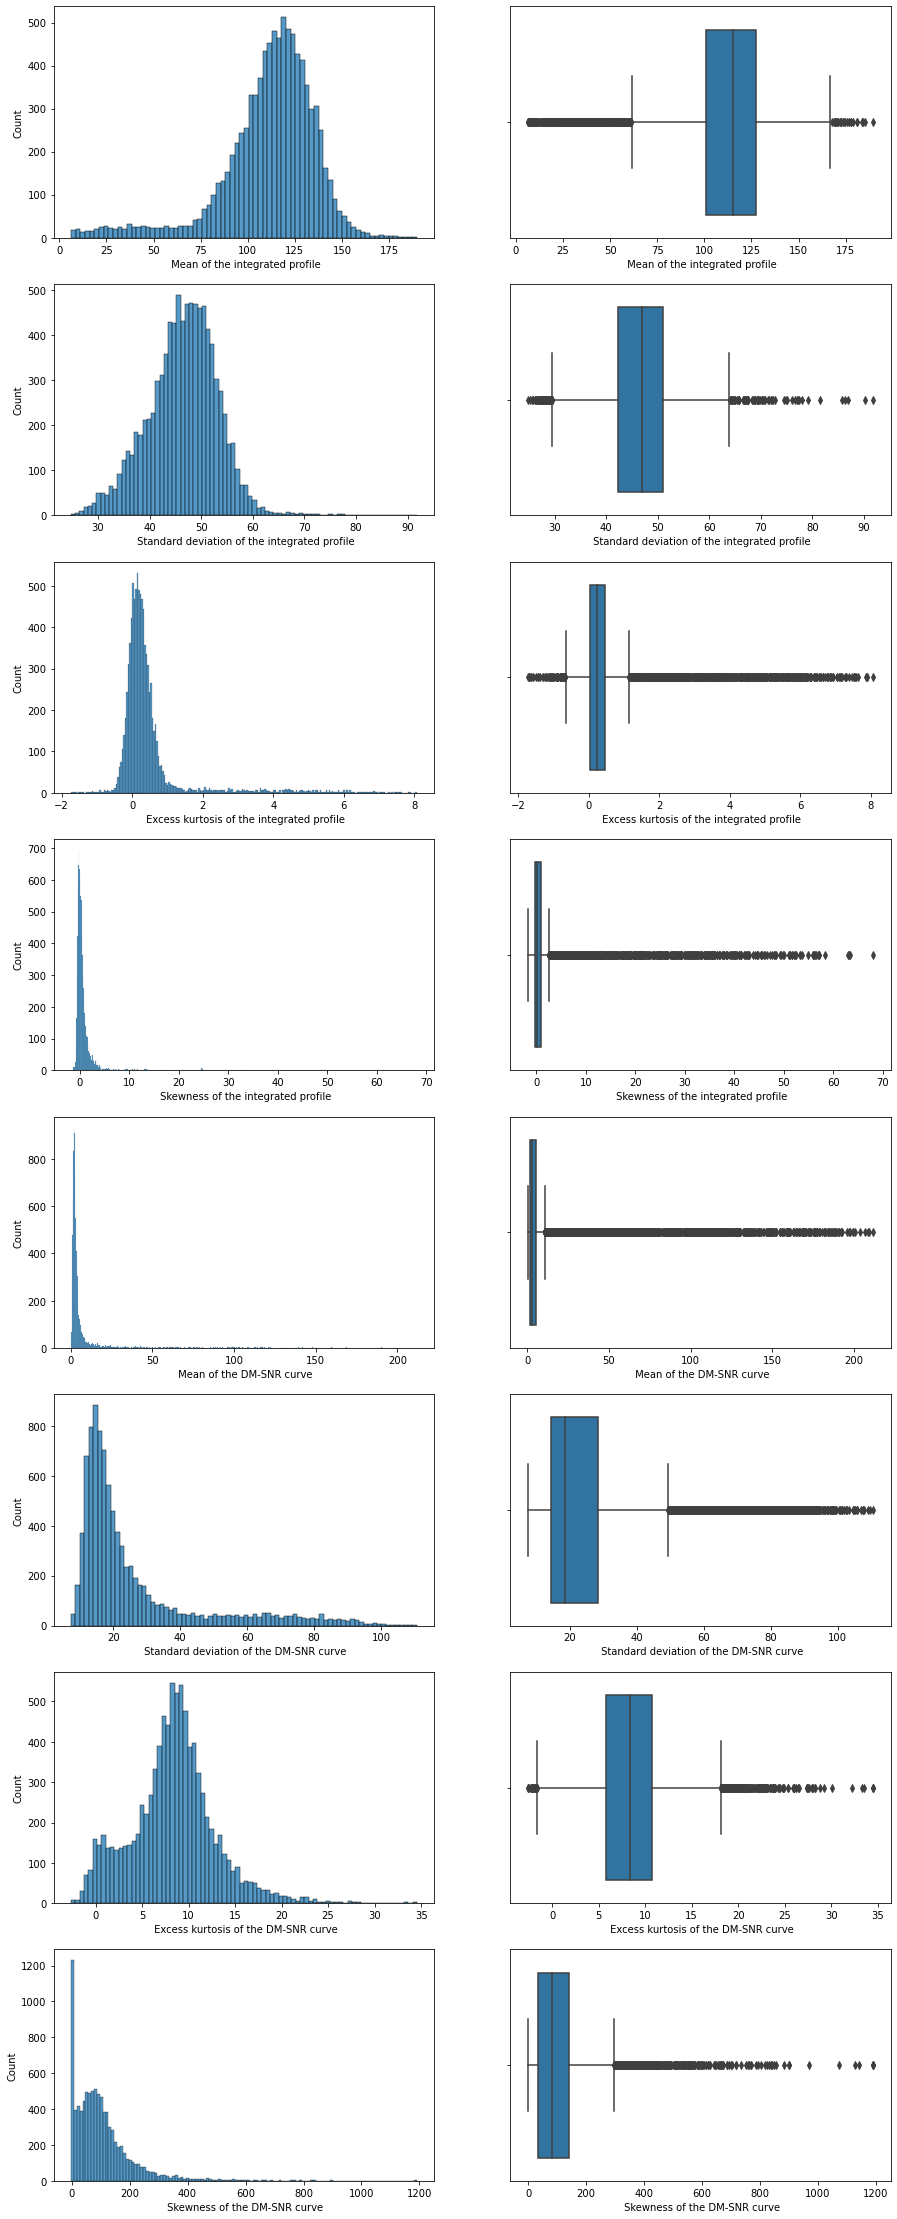

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [122]:
fig, axes = plt.subplots(nrows=D,ncols=2,  figsize=(15, 40))
for i in range(D):
    feature = feature_names[i]
    plt.figure(figsize = (5, 5))
    sns.histplot(x=df[feature], ax=axes[i][0])
    sns.boxplot(x=df[feature], ax=axes[i][1])

# Plotting p(X|Y)

Below we see boxplots applied to the features conditioned on each of the target values (0 and 1). A feature whose two conditional distributions are well-separated will likely be a good feature for classification.

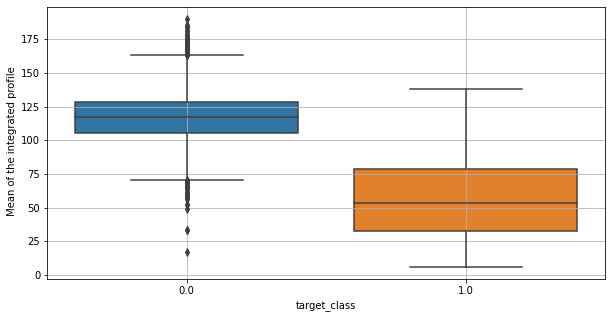

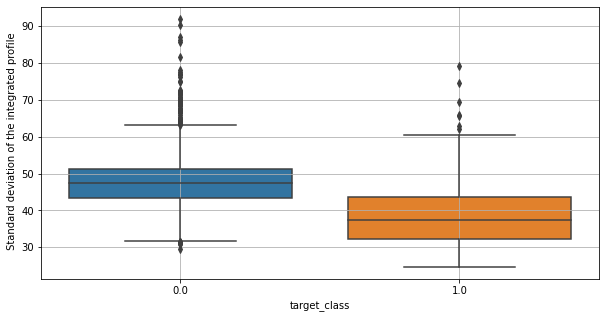

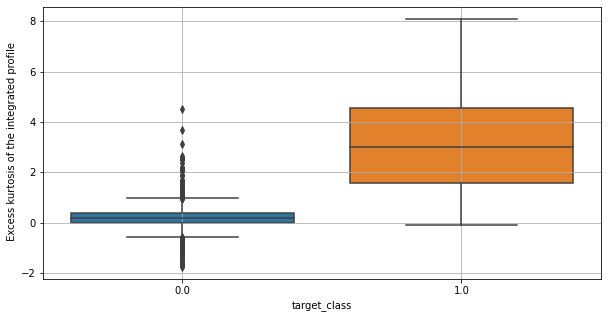

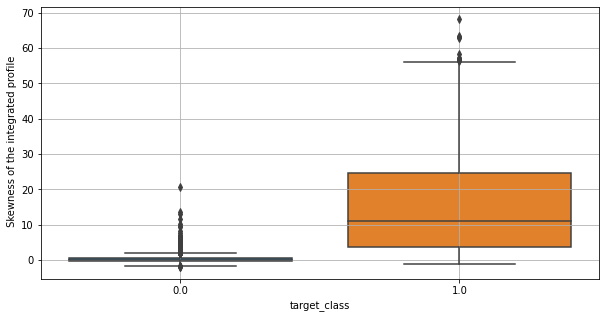

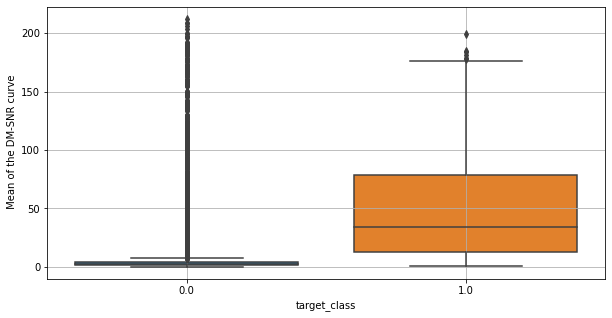

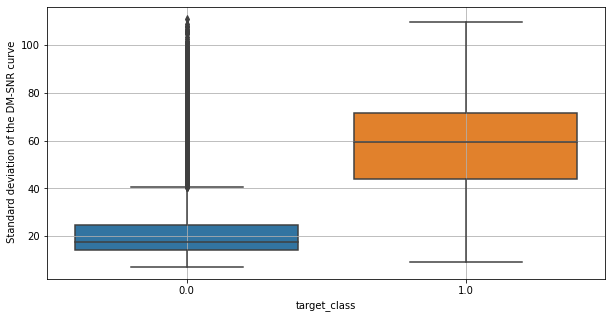

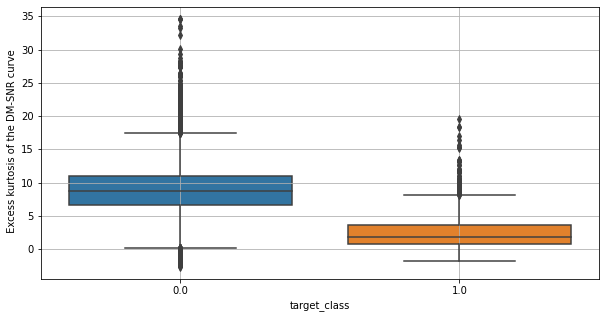

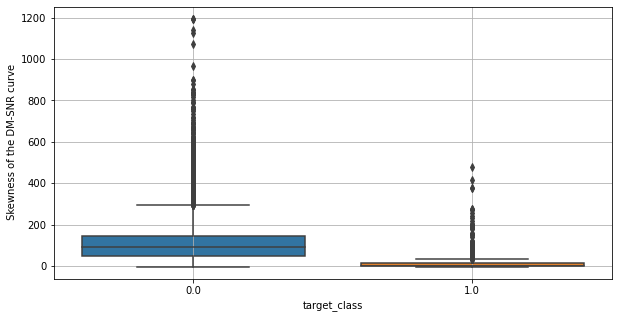

In [123]:
for feature in feature_names:
    plt.figure(figsize = (10, 5))
    sns.boxplot(x='target_class', y=feature, data=df)
    plt.grid()

# Correlation matrix (X,Y)
The next cell color-codes the correlation matrix of (X,Y).
+ Which two features are most correlated with each other?
+ Which features are most correlated with the output?

<AxesSubplot:>

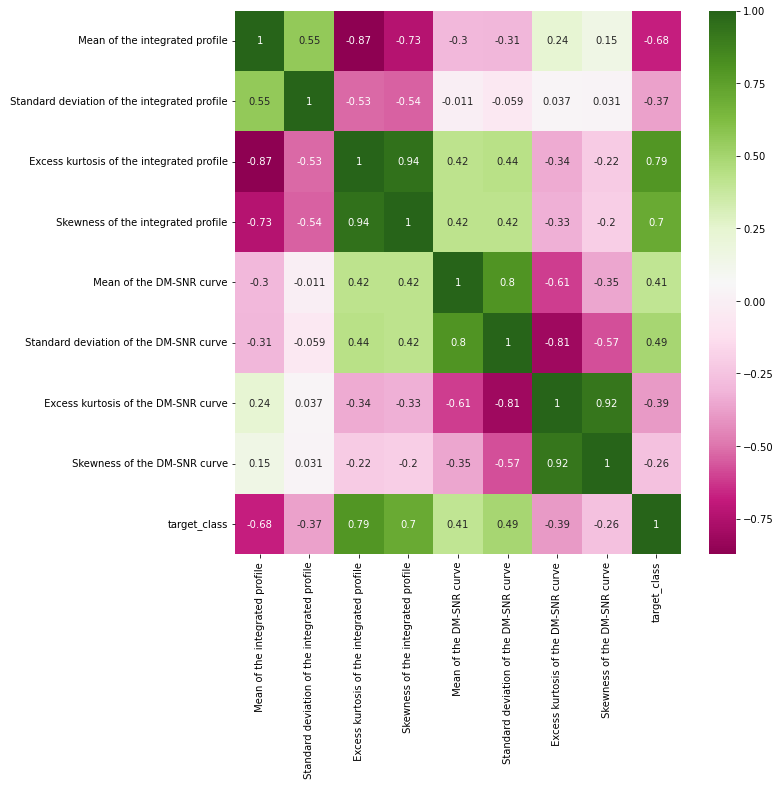

In [124]:
# most correlated to each other: (0,2), (2,3), (4,5), (5,6), (6,7)
# most correlated to the output: 0,2,3

plt.figure(figsize = (10, 10))
corr_mat = df.corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, yticklabels = corr_mat.columns, annot=True, cmap="PiYG")

# 4. Extracting the test dataset

Split the dataset contained in `df` into trainging and testing parts, with 90% used for training and 10% for testing. Remember to set the `random_state` to `rng_seed`.

In [141]:
#print(df[feature_names])

In [142]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df[feature_names], df['target_class'], test_size=0.9, random_state=rng_seed)

In [143]:
grader.check("q4")

q4 results: All test cases passed!

# 5.1. Logistic Regression

In this part we will use grid search to choose the values of the hyperparameters of a logistic regression pipeline. Begin by creating a pipeline with a `StandardScaler` followed by `LogisticRegression` classifier. Pass these parameters to the contructor of the logistic regression classifier:
+ `solver`: `liblinear`
+ `random_state`: `rng_seed`

Then fit the model using the training data.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler' , ... ) ,
    ('clf' , ... )
])
model.fit(...)

In [ ]:
grader.check("q5p1")

# 5.2 Hyperparameter tuning with grid search

Run gridsearch (`GridSearchCV`) with 5-fold cross validation. The parameters to search over are:

+ the regularization function ('l1' or 'l2'), and
+ the value of C. C should take values np.logspace(-4, 4, 5).

Note, for `GridSearchCV` to work with the pipeline, it has to set the parameters of the model using their string names. Within the pipeline, the parameters of the model are prefixed with `clf__`. Hence, to set the penalty of logistic regression to `l1` or `l2`, you must include key-value pair `clf__penalty : ['l1','l2']` in `param_grid`.

Pass the following parameters to the `GridSearchCV` contructor.
+ `scoring=['accuracy', 'precision','recall']`,
+ `cv=5`,
+ `refit='accuracy'`

`lab6_utils.py` contains useful functions for unpacking and plotting the results of the grid search. Use the `unpack_gridsearch` method to extract useful information from the grid search solution. This method returns:
1. A pandas dataframe with the cross-validated performance metrics for each point on the grid.
2. A dictionary with the best-case hyperparameter values
3. The classifier with best-case hyperparameters assigned


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_logreg = {
    'clf__penalty' : ...,
    'clf__C' : ...}

grid = GridSearchCV(...)

grid_result = grid.fit(..., ...)

df_logreg, best_param_logreg, best_logreg = lab6.unpack_gridsearch(...)

# Visualize with plot_grid (included in lab6_utils.py)
lab6.plot_grid(df_logreg,param_grid_logreg)

In [ ]:
grader.check("q5p2")

# Package it into a function

Next we will repeat this process with several other classification models. To keep the code clean, I suggest you collect the steps into a single function. This function should receive as inputs:
1. The classifier object, e.g. `LogisticRegression(solver='liblinear',random_state=rng_seed)`
2. The `param_grid` dictionary that defines the search space for `GridSearchCV`.

It should:
1. Create the pipeline mode
2. Construct the `GridSearchCV` object
3. Run `fit` on the grid search object, using the training data (no need to pass the data in, it's global)
4. Run `unpack_gridsearch` to obtain `df`, `best_params`, `best_clf`
5. Plot the result with `lab6.plot_grid`
6. `retun df_clf, best_param_clf, best_clf`

In [ ]:
def build_grid_plot(clf,param_grid):
    model = Pipeline(...)

    grid = GridSearchCV(...)

    grid_result = grid.fit(...)

    df_clf, best_param_clf, best_clf  = lab6.unpack_gridsearch(...)

    lab6.plot_grid(...)

    return df_clf, best_param_clf, best_clf

# Additional models
Next we will repeat this exercise for four additional model types: SVMs, Random forests, AdaBoost, and Gradient boosted trees. In each case, use the suggested parameter grid. **Remember to always set the random state for the model in its constructor.**

# 6. Support vector machine

+ kernel: ['poly','rbf']
+ C: np.logspace(-2, 2, 5)

In [ ]:
%%time
from sklearn.svm import SVC
param_grid_svm = ...
df_svc, best_param_svc, best_svc = build_grid_plot(...)

In [ ]:
grader.check("q6")

# 7. Random forest

+ max_features: ['sqrt','log2']
+ n_estimators: np.linspace(2, 100, 5, dtype=int)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = ...
df_rf, best_param_rf, best_rf = build_grid_plot(...)

In [ ]:
grader.check("q7")

# 8. AdaBoost

+ learning_rate: [0.01,0.1]
+ n_estimators: np.linspace(10, 100, 5, dtype=int)

In [ ]:
%%time

from sklearn.ensemble import AdaBoostClassifier

param_grid_ab = ...
df_ab, best_param_ab, best_ab = build_grid_plot(...)

In [ ]:
grader.check("q8")

# 9. Gradient Boosted Trees

+ learning_rate: [0.1,1.0]
+ n_estimators' : [50,75,100]


In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = ...
df_gbc, best_param_gbc, best_gbc = build_grid_plot(...)


In [ ]:
grader.check("q9")

# 10. Final model selection

Choose the best classifier on the basis of the accuracy obtained in the grid search. Assign it to `my_best_clf`. Then compute the test accuracy, precision, and recall.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
my_best_clf = ...
ypred = my_best_clf.predict(Xtest)
print(accuracy_score(ytest, ypred))
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))

In [ ]:
grader.check("q10")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)